In [1]:
import os
import torch
import torch.nn as nn
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

from glob import glob
from os.path import join
from os import listdir
from pathlib import Path


from torch import optim
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torch.nn.modules.loss import L1Loss
from torch.nn.modules.loss import MSELoss


def numpy_from_tensor(x):
  return x.detach().cpu().numpy()

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Part 1
Write a segmentation algorithm pipeline. Train on the training set, defined as a proportion of the data in imagesTr, and validate the algorithm performance on the remaining images. Do not use any auwgmentation for now. Use any choice of optimiser. Describe how the algorithm was trained, and what were the final results using standard image segmentation validation metrics such as Dice Score or Hausdorff Distance.

In [51]:
# In this cell the creation of a class dataset is carried out
# The class allows to perform transformations to both the image and the mask

from torchvision import transforms
class SpleenDataset(Dataset):
    def __init__(self, data, masks=None, img_transforms=None, mask_transforms=None):
        
        self.data = data
        self.masks = masks
        self.img_transforms = img_transforms
        self.mask_transforms = mask_transforms

        self.images = sorted(os.listdir(self.data))
        self.labels = sorted(os.listdir(self.masks))

    def __len__(self):
        if self.masks is not None:
            assert len(self.images) == len(self.labels), 'number of labels do not match number of images'
        return (len(self.images))

    def __getitem__(self, idx):
        image_name = os.path.join(self.data, self.images[idx])
        img = nib.load(image_name)
        img = np.array(img.get_fdata())
        trans = transforms.ToTensor()
        img = trans(img)

        # Apply transforms
        if self.img_transforms is not None:
            img = self.img_transforms(img)
        img = torch.unsqueeze(img, 0)  

        if self.masks is not None:
            mask_name = os.path.join(self.masks, self.labels[idx])
            mask = nib.load(mask_name)
            mask = np.array(mask.get_fdata())
            mask = trans(mask)

            # Apply transforms
            if self.mask_transforms is not None:
                mask = self.mask_transforms(mask)
            mask = torch.unsqueeze(mask, 0)

            # Make sure that pixels <= 0 do not belong to the spleen
            mask = torch.where(mask <= 0.0, torch.tensor([0.0]), torch.tensor([1.0]))
                
        return img, mask


In [52]:
# Create a class that resizes all images to 64x128x128
# This is to have consistency with other team members and to save memory when training

import torch.nn.functional as F
class StandardResize:
    def __call__(self, tensor):
        tensor = tensor.unsqueeze(0)  # add batch dimension
        tensor = tensor.unsqueeze(1)  # add channel dimension
        tensor = F.interpolate(tensor, size=(64, 128, 128), mode='trilinear', align_corners=False)
        tensor = tensor.squeeze(1)  # remove channel dimension
        tensor = tensor.squeeze(0)  # remove batch dimension
        return tensor

In [53]:
# Create a class that normalises the data before passing it to the network to improve performance

class MyNormalize(object):
    def __call__(self, tensor):
        # rescale the tensor to range [0, 1]
        min_val = tensor.min()
        max_val = tensor.max()
        tensor = (tensor - min_val) / (max_val - min_val)
        
        # compute mean and standard deviation of the entire dataset
        mean = torch.mean(tensor)
        std = torch.std(tensor)
        
        # normalize the tensor
        tensor = (tensor - mean) / std
        
        return tensor

In [54]:
# Create dataloaders
DATA_PATH = '/content/drive/MyDrive/FinalProjectML/Task09_Spleen/imagesTr'
MASK_PATH = '/content/drive/MyDrive/FinalProjectML/Task09_Spleen/labelsTr'

# Create transforms
transform_img = transforms.Compose([StandardResize(), MyNormalize()])
transform_mask = transforms.Compose([StandardResize()])

# Create data and devide it into train and validation
my_data = SpleenDataset(data=DATA_PATH, masks=MASK_PATH, img_transforms=transform_img, mask_transforms=transform_mask)
print(f'Data set length: {my_data.__len__()}')

train = torch.utils.data.Subset(my_data, range(30))
validation = torch.utils.data.Subset(my_data, range(30, 41))

train_data = torch.utils.data.DataLoader(train, batch_size=4, shuffle=True)
validation_data = torch.utils.data.DataLoader(validation, batch_size=4, shuffle=False)

# check the shape of the batches
im_batch, lab_batch = next(iter(train_data)) # get a batch
print(f'image batch shape:, {im_batch.shape}')
print(f'label batch shape:, {lab_batch.shape}')

Data set length: 41
image batch shape:, torch.Size([4, 1, 64, 128, 128])
label batch shape:, torch.Size([4, 1, 64, 128, 128])


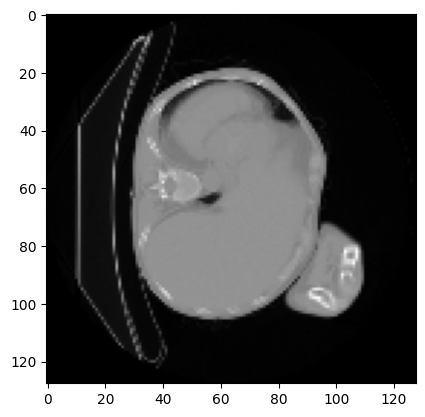

In [ ]:
# Visualise a slide of an image of the training data
plt.imshow(im_batch[0, 0, 50, :, :], cmap='gray')

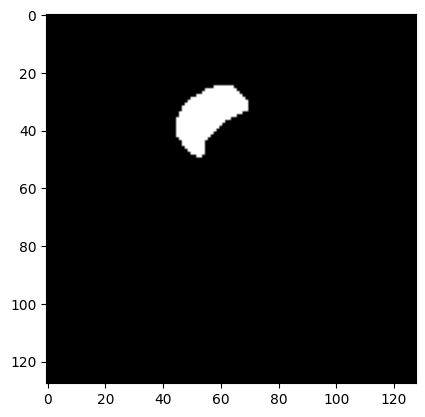

In [ ]:
# Visualise a slide of a label of the training data
plt.imshow(lab_batch[0, 0, 50, :, :], cmap='gray')

In [ ]:
# Define a convolution class
class MyConv(nn.Module):
    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.conv1 = nn.Conv3d(channels_in, channels_out, kernel_size=3, stride=1, padding=1)
    def forward(self, x):
        return self.conv1(x)

# Create a double conv class for the unet
class DoubleConv(nn.Module):
    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.double_conv = nn.Sequential(
            MyConv(channels_in, channels_out),
            nn.BatchNorm3d(channels_out),
            nn.ReLU(),

            MyConv(channels_out, channels_out),
            nn.BatchNorm3d(channels_out),
            nn.ReLU(),
        )
    def forward(self, x):
        return self.double_conv(x)

# Create a class for the encoder part of the unet
class DownConv(nn.Module):
    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.MaxPool3d(2, 2),
            DoubleConv(channels_in, channels_out)
        )
    def forward(self, x):
        return self.encoder(x)

# Create a class for the decoder part of the unet
class UpConv(nn.Module):
    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.upsample_layer = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='trilinear'),
            nn.Conv3d(channels_in, channels_in//2, kernel_size=1, stride=1)
        )
        self.decoder = DoubleConv(channels_in, channels_out)
    def forward(self, x1, x2):
        x1 = self.upsample_layer(x1)
        x = torch.cat([x2, x1], dim=1)
        return self.decoder(x)

In [ ]:
# Create a UNET class using the classes defined in the previous cell
class UNET(nn.Module):
    def __init__(self, channels_in, channels, num_classes):
        super().__init__()
        self.first_conv = DoubleConv(channels_in, channels)
        self.down_conv1 = DownConv(channels, 2*channels)
        self.down_conv2 = DownConv(2*channels, 4*channels)
        self.down_conv3 = DownConv(4*channels, 8*channels)

        self.down_conv4 = DownConv(8*channels, 16*channels)

        self.up_conv1 = UpConv(16*channels, 8*channels)
        self.up_conv2 = UpConv(8*channels, 4*channels)
        self.up_conv3 = UpConv(4*channels, 2*channels)
        self.up_conv4 = UpConv(2*channels, channels)

        self.final_conv = nn.Conv3d(channels, num_classes, kernel_size=1, stride=1)

    def forward(self, x):
        x1 = self.first_conv(x)
        x2 = self.down_conv1(x1)
        x3 = self.down_conv2(x2)
        x4 = self.down_conv3(x3)

        x5 = self.down_conv4(x4)

        u1 = self.up_conv1(x5, x4)
        u2 = self.up_conv2(u1, x3)
        u3 = self.up_conv3(u2, x2)
        u4 = self.up_conv4(u3, x1)

        return self.final_conv(u4)

In [66]:
# using dice loss from   https://github.com/kevinzakka/pytorch-goodies/blob/master/losses.py

def dice_coeff(pred, target):
   

    epsilon = 10e-8
    dims = (0,) + tuple(range(2, target.ndimension()))
    intersection = torch.sum(pred * target, dims)
    cardinality = torch.sum(pred + target, dims)
    
    dice = (2. * intersection / (cardinality + epsilon))
    dice_loss=dice.mean()

    return dice_loss

In [ ]:
# Create training loop, define model, loss, and optimiser

model = UNET(1, 8, 2).to(device)
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
epochs=200
mean_train_dice=[]
mean_val_dice=[]

for epoch in range(epochs):

    ##########
    # Train
    ##########
    
    model.train() 
    train_dice= []

    for i, (data, label) in enumerate(train_data):
        data = data.to(device=device, dtype=torch.float32)
        label= label.to(device=device, dtype=torch.long)

        optimiser.zero_grad() 
        pred = model(data)
        err = loss_fn(pred, label.squeeze(1))
        err.backward()
        optimiser.step()     
        dice_value=dice_coeff(pred, label).item()
        print('[{:d}/{:d}][{:d}/{:d}] Dice: {:.4f} '
              .format(epoch, epochs, i, len(train_data), dice_value))

        train_dice.append(dice_value)
      

    # #############
    # # Validation
    # #############
    
    # set network to eval prior to training loop 
    model.eval()
    val_dice= []
    for i, (data, label) in enumerate(validation_data):
        data=data.to(device=device, dtype=torch.float32)
        label=label.to(device=device, dtype=torch.long)    

        pred = model(data)
        
        err = loss_fn(pred, label.squeeze(1))
       
        val_dice.append(dice_coeff(pred, label).item())

        
    mean_val_dice.append(np.mean(val_dice))
    mean_train_dice.append(np.mean(train_dice))

   

    print('Val Dice: {}, Train Dice: {:.4f}'.format(np.mean(mean_val_dice),np.mean(train_dice)))

[0/200][0/8] Dice: 0.0012 
[0/200][1/8] Dice: 0.0174 
[0/200][2/8] Dice: 0.0125 
[0/200][3/8] Dice: 0.0112 
[0/200][4/8] Dice: 0.0103 
[0/200][5/8] Dice: 0.0167 
[0/200][6/8] Dice: 0.0086 
[0/200][7/8] Dice: 0.0141 
Val Dice: 0.007519739912822843, Train Dice: 0.0115
[1/200][0/8] Dice: 0.0135 
[1/200][1/8] Dice: 0.0106 
[1/200][2/8] Dice: 0.0158 
[1/200][3/8] Dice: 0.0093 
[1/200][4/8] Dice: 0.0166 
[1/200][5/8] Dice: 0.0144 
[1/200][6/8] Dice: 0.0109 
[1/200][7/8] Dice: 0.0059 
Val Dice: 0.009205264155752957, Train Dice: 0.0121
[2/200][0/8] Dice: 0.0108 
[2/200][1/8] Dice: 0.0116 
[2/200][2/8] Dice: 0.0131 
[2/200][3/8] Dice: 0.0109 
[2/200][4/8] Dice: 0.0114 
[2/200][5/8] Dice: 0.0131 
[2/200][6/8] Dice: 0.0096 
[2/200][7/8] Dice: 0.0121 
Val Dice: 0.010727277931032909, Train Dice: 0.0116
[3/200][0/8] Dice: 0.0168 
[3/200][1/8] Dice: 0.0101 
[3/200][2/8] Dice: 0.0065 
[3/200][3/8] Dice: 0.0122 
[3/200][4/8] Dice: 0.0092 
[3/200][5/8] Dice: 0.0108 
[3/200][6/8] Dice: 0.0124 
[3/200][7/

In [ ]:
# Save the model
# torch.save(model.state_dict(), '/content/drive/MyDrive/FinalProjectML/model_1_1.pt')

In [ ]:
# Load the model
loaded_model = UNET(1, 8, 2)
loaded_model.load_state_dict(torch.load('/content/drive/MyDrive/FinalProjectML/model_1_1.pt', map_location=torch.device(device)))
loaded_model.eval()

UNET(
  (first_conv): DoubleConv(
    (double_conv): Sequential(
      (0): MyConv(
        (conv1): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      )
      (1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MyConv(
        (conv1): Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      )
      (4): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (down_conv1): DownConv(
    (encoder): Sequential(
      (0): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): MyConv(
            (conv1): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          )
          (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): MyConv(
        

In [ ]:
# Get an image and a label from the validation set
im_batch, lab_batch = next(iter(validation_data))

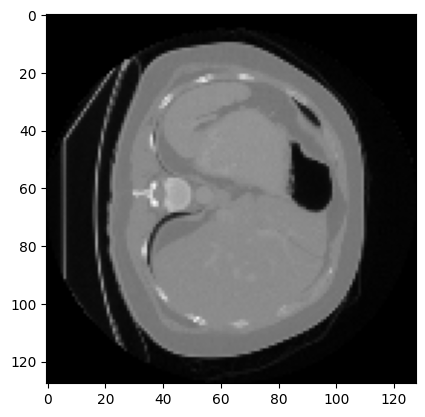

In [ ]:
# Visualise a slide of the image
plt.imshow(im_batch[3, 0, 45, :, :], cmap='gray')

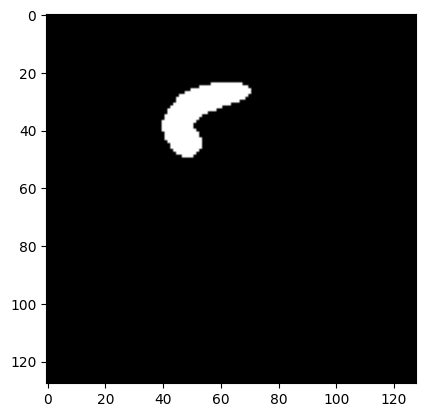

In [ ]:
# Visualise a slide of the label
plt.imshow(lab_batch[3, 0, 45, :, :], cmap='gray')

torch.Size([4, 2, 64, 128, 128])
torch.Size([4, 64, 128, 128])


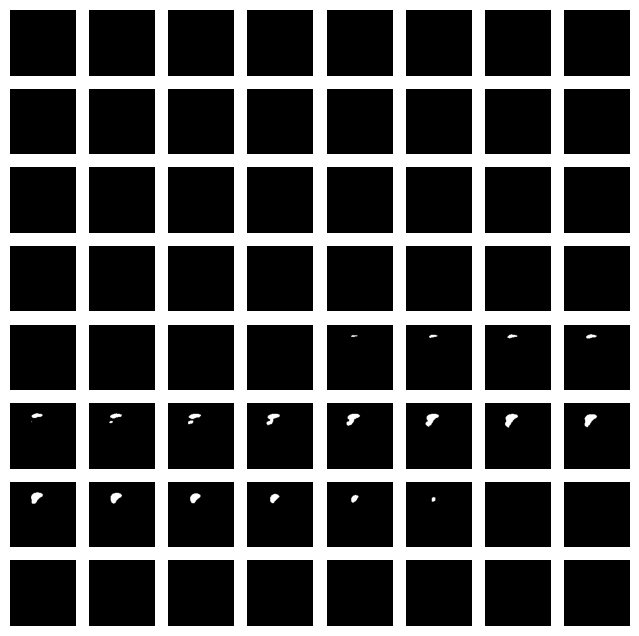

In [ ]:
# Visualise the segmentation produced by the model when passing the image from the previous cell

my_seg = loaded_model(im_batch.to(dtype=torch.float32))
print(my_seg.shape)
my_seg = torch.argmax(my_seg, dim=1).float()
print(my_seg.shape)

rows = 8
cols = 8

fig = plt.figure(figsize=(8, 8))
plt.tight_layout()


for i in range(64):
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(my_seg[2, i, :, :].detach().numpy(), cmap='gray')
    plt.axis('off')

In [ ]:
# Calculate validation dice for the network of task 1
validation_data2 = torch.utils.data.DataLoader(validation, batch_size=1, shuffle=False)
loaded_model.to(device)
list_of_dice = []
for i, (data, label) in enumerate(validation_data2):
    data = data.to(device=device, dtype=torch.float32)
    label= label.to(device=device, dtype=torch.long)
    results = loaded_model(data)
    dice = dice_coeff(results.argmax(dim=1), label).cpu().numpy()
    list_of_dice.append(dice)

print(np.mean(list_of_dice))

0.89053476


In [ ]:
# Save the segmentations for the network of task 1

all_data = torch.utils.data.DataLoader(my_data, batch_size=1, shuffle=False)
len(all_data)

for i, (data, label) in enumerate(all_data):
    data = data.to(device=device, dtype=torch.float32)
    label= label.to(device=device, dtype=torch.long)
    results = loaded_model(data)
    my_seg = torch.argmax(results, dim=1).float()
    my_seg = my_seg.squeeze(dim=0)
    img = nib.Nifti1Image(my_seg.cpu().numpy(), affine=np.eye(4))
    nib.save(img, f'/content/drive/MyDrive/FinalProjectML/my_segmentations_1/label_{i+1}_MF.nii.gz')


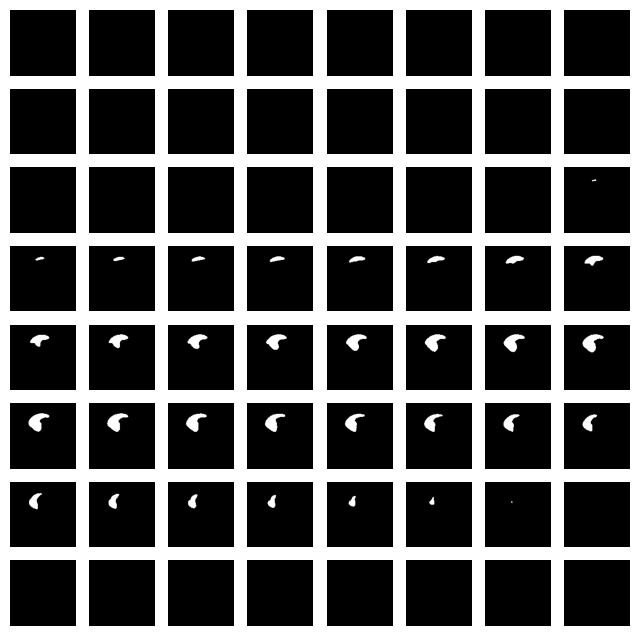

In [ ]:
# Visualise first segmentation from the saved segmentations

loaded_seg = nib.load('/content/drive/MyDrive/FinalProjectML/my_segmentations_1/label_2_MF.nii.gz')
loaded_seg = loaded_seg.get_fdata()
loaded_seg = torch.from_numpy(loaded_seg)
loaded_seg.shape

rows = 8
cols = 8
fig = plt.figure(figsize=(8, 8))
plt.tight_layout()

for i in range(64):
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(loaded_seg[i, :, :].numpy(), cmap='gray')
    plt.axis('off')

### Part 2
Now run the same training process but now using Affine transformations and Elastic Deformations as augmentation techniques.

In [ ]:
# Modify the Dataset Class so augmentation can be applied to both image and label

from torchvision import transforms
class SpleenDataset_2(Dataset):
    def __init__(self, data, masks=None, data_augmentation=None):
        

        self.data = data
        self.masks = masks
        self.data_augmentation = data_augmentation

        self.images = sorted(os.listdir(self.data))
        self.labels = sorted(os.listdir(self.masks))

    def __len__(self):
        return (len(self.images))

    def __getitem__(self, idx):
        image_name = os.path.join(self.data, self.images[idx])
        img = nib.load(image_name)
        img = np.array(img.get_fdata())
        trans = transforms.Compose([transforms.ToTensor(), StandardResize(), MyNormalize()])
        img = trans(img)

 

        trans_masks = transforms.Compose([transforms.ToTensor(), StandardResize()])
        mask_name = os.path.join(self.masks, self.labels[idx])
        mask = nib.load(mask_name)
        mask = np.array(mask.get_fdata())
        mask = trans_masks(mask)

        # Apply augmentations
        if self.data_augmentation is not None:
            img, mask = self.data_augmentation(img, mask)

        mask = torch.unsqueeze(mask, 0)
        mask = torch.where(mask <= 0.0, torch.tensor([0.0]), torch.tensor([1.0]))
        img = torch.unsqueeze(img, 0)       
        return img, mask

In [ ]:
# Create a class for transformations for data augmentation. In this case this class contains Affine transformations (rotation, translations, shears)
import random
class CustomTransform(object):
    def __init__(self, angle, translate, shear):
        self.angle = angle
        self.translate = translate
        self.shear = shear
        
    def __call__(self, img, mask):
        # Apply the same rotation to both the image and its mask
        angle = random.uniform(-self.angle, self.angle)
        img = transforms.functional.rotate(img, angle)
        mask = transforms.functional.rotate(mask, angle)

        # Apply the same translation to both the image and its mask
        x_translate = random.uniform(-self.translate, self.translate)
        y_translate = random.uniform(-self.translate, self.translate)
        img = transforms.functional.affine(img, angle=0, translate=[x_translate, y_translate], scale=1, shear=0, fill=0)
        mask = transforms.functional.affine(mask, angle=0, translate=[x_translate, y_translate], scale=1, shear=0, fill=0)

        # Apply the same shear to both the image and its mask
        x_shear = random.uniform(-self.shear, self.shear)
        y_shear = random.uniform(-self.shear, self.shear)
        img = transforms.functional.affine(img, angle=0, translate=[0, 0], scale=1, shear=[x_shear, y_shear], fill=0)
        mask = transforms.functional.affine(mask, angle=0, translate=[0, 0], scale=1, shear=[x_shear, y_shear], fill=0)


        return img, mask

image batch shape:, torch.Size([4, 1, 64, 128, 128])
label batch shape:, torch.Size([4, 1, 64, 128, 128])


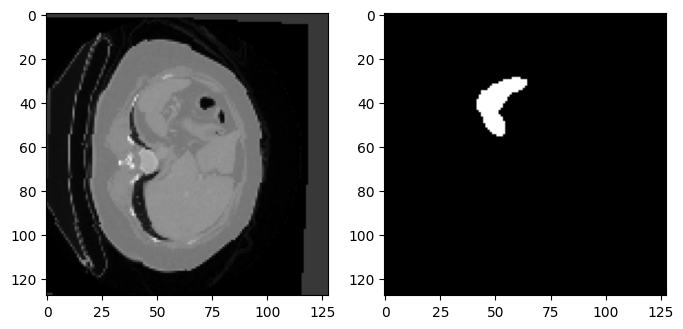

In [ ]:
# Create new data loader and apply augmentation

DATA_PATH = '/content/drive/MyDrive/FinalProjectML/Task09_Spleen/imagesTr'
MASK_PATH = '/content/drive/MyDrive/FinalProjectML/Task09_Spleen/labelsTr'


my_data_aug = SpleenDataset_2(data=DATA_PATH, masks=MASK_PATH, data_augmentation=CustomTransform(angle=10, translate=10, shear=0.1))

train = torch.utils.data.Subset(my_data_aug, range(30))
validation = torch.utils.data.Subset(my_data_aug, range(30, 41))

train_data = torch.utils.data.DataLoader(train, batch_size=4, shuffle=True)
validation_data = torch.utils.data.DataLoader(validation, batch_size=4, shuffle=False)

# Print image and label batch shapes

im_batch, lab_batch = next(iter(train_data)) # get a batch
print(f'image batch shape:, {im_batch.shape}')
print(f'label batch shape:, {lab_batch.shape}')

# Visualise that augmentation was perform correctly to both image and label
rows = 1
cols = 2
fig = plt.figure(figsize=(8, 8))
plt.tight_layout()
fig.add_subplot(rows, cols, 1)
plt.imshow(im_batch[0, 0, 40, :, :].numpy(), cmap='gray')
fig.add_subplot(rows, cols, 2)
plt.imshow(lab_batch[0, 0, 40, :, :].numpy(), cmap='gray')

In [ ]:
# Create training loop, define model, loss, and optimiser
model_aug = UNET(1, 8, 2).to(device)
optimiser = torch.optim.Adam(model_aug.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
epochs=200
mean_train_dice=[]
mean_val_dice=[]

for epoch in range(epochs):

    ##########
    # Train
    ##########
    
    model_aug.train() 
    train_dice= []

    for i, (data, label) in enumerate(train_data):
        data = data.to(device=device, dtype=torch.float32)
        label= label.to(device=device, dtype=torch.long)

        optimiser.zero_grad() 
        pred = model_aug(data)
        err = loss_fn(pred, label.squeeze(1))
        err.backward()
        optimiser.step()
        
        dice_value=dice_coeff(pred.argmax(dim=1), label).item()
        
        print('[{:d}/{:d}][{:d}/{:d}] Dice: {:.4f} '
              .format(epoch, epochs, i, len(train_data), dice_value))

        train_dice.append(dice_value)
      

    # #############
    # # Validation
    # #############
    
    # set network to eval prior to training loop 
    model_aug.eval()
    val_dice= []
    for i, (data, label) in enumerate(validation_data):
        data=data.to(device=device, dtype=torch.float32)
        label=label.to(device=device, dtype=torch.long)    

        pred = model_aug(data)
        
        err = loss_fn(pred, label.squeeze(1))
       
        val_dice.append(dice_coeff(pred.argmax(dim=1), label).item())

        
    mean_val_dice.append(np.mean(val_dice))
    mean_train_dice.append(np.mean(train_dice))

   

    print('Val Dice: {}, Train Dice: {:.4f}'.format(np.mean(mean_val_dice),np.mean(train_dice)))

[0/200][0/8] Dice: 0.0085 
[0/200][1/8] Dice: 0.0061 
[0/200][2/8] Dice: 0.0071 
[0/200][3/8] Dice: 0.0094 
[0/200][4/8] Dice: 0.0067 
[0/200][5/8] Dice: 0.0113 
[0/200][6/8] Dice: 0.0109 
[0/200][7/8] Dice: 0.0100 
Val Dice: 0.01334278533856074, Train Dice: 0.0087
[1/200][0/8] Dice: 0.0111 
[1/200][1/8] Dice: 0.0035 
[1/200][2/8] Dice: 0.0104 
[1/200][3/8] Dice: 0.0104 
[1/200][4/8] Dice: 0.0061 
[1/200][5/8] Dice: 0.0074 
[1/200][6/8] Dice: 0.0041 
[1/200][7/8] Dice: 0.0178 
Val Dice: 0.014362047426402569, Train Dice: 0.0089
[2/200][0/8] Dice: 0.0075 
[2/200][1/8] Dice: 0.0020 
[2/200][2/8] Dice: 0.0029 
[2/200][3/8] Dice: 0.0055 
[2/200][4/8] Dice: 0.0031 
[2/200][5/8] Dice: 0.0069 
[2/200][6/8] Dice: 0.0037 
[2/200][7/8] Dice: 0.0057 
Val Dice: 0.02230294773148166, Train Dice: 0.0047
[3/200][0/8] Dice: 0.0044 
[3/200][1/8] Dice: 0.0045 
[3/200][2/8] Dice: 0.0051 
[3/200][3/8] Dice: 0.0069 
[3/200][4/8] Dice: 0.0046 
[3/200][5/8] Dice: 0.0057 
[3/200][6/8] Dice: 0.0036 
[3/200][7/8]

In [ ]:
# Save the model
# torch.save(model_aug.state_dict(), '/content/drive/MyDrive/FinalProjectML/model_2_1.pt')

In [ ]:
# Load the model
loaded_model_2 = UNET(1, 8, 2)
loaded_model_2.load_state_dict(torch.load('/content/drive/MyDrive/FinalProjectML/model_2_1.pt', map_location=torch.device(device)))
loaded_model_2.eval()

UNET(
  (first_conv): DoubleConv(
    (double_conv): Sequential(
      (0): MyConv(
        (conv1): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      )
      (1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MyConv(
        (conv1): Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      )
      (4): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (down_conv1): DownConv(
    (encoder): Sequential(
      (0): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): MyConv(
            (conv1): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          )
          (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): MyConv(
        

In [ ]:
# Calculate Validation Dice
# To make a fair comparison between the models, the same validation data (without augmentation) is used

loaded_model_2.to(device)
list_of_dice = []
for i, (data, label) in enumerate(validation_data2):
    data = data.to(device=device, dtype=torch.float32)
    label= label.to(device=device, dtype=torch.long)
    results = loaded_model_2(data)
    dice = dice_coeff(results.argmax(dim=1), label).cpu().numpy()
    list_of_dice.append(dice)

print(np.mean(list_of_dice))

0.857428


### Part 3
To obtain even better results, you will need to optimise the parameters of the loss function, the optimiser learning rate, or the network parameters.

In [ ]:
# Create a dataset
DATA_PATH = '/content/drive/MyDrive/FinalProjectML/Task09_Spleen/imagesTr'
MASK_PATH = '/content/drive/MyDrive/FinalProjectML/Task09_Spleen/labelsTr'

my_data = SpleenDataset(data=DATA_PATH, masks=MASK_PATH, img_transforms=transform_img, mask_transforms=transform_mask)
train = torch.utils.data.Subset(my_data, range(30))
validation = torch.utils.data.Subset(my_data, range(30, 41))

train_data = torch.utils.data.DataLoader(train, batch_size=4, shuffle=True)
validation_data = torch.utils.data.DataLoader(validation, batch_size=4, shuffle=False)

# Print image and label batch shapes
im_batch, lab_batch = next(iter(train_data)) # get a batch
print(f'image batch shape:, {im_batch.shape}')
print(f'label batch shape:, {lab_batch.shape}')

image batch shape:, torch.Size([4, 1, 64, 128, 128])
label batch shape:, torch.Size([4, 1, 64, 128, 128])


In [ ]:
# Create a training loop, this times the parameters optimised were the number of epochs, the number of initial channels, and the learning rate
# Explanations are in the report

model_optim = UNET(1, 10, 2).to(device)
optimiser = torch.optim.Adam(model_optim.parameters(), lr=0.0001)
loss_fn = nn.CrossEntropyLoss()
epochs=250
mean_train_dice=[]
mean_val_dice=[]

for epoch in range(epochs):

    ##########
    # Train
    ##########
    
    model_optim.train() 
    train_dice= []

    for i, (data, label) in enumerate(train_data):
        data = data.to(device=device, dtype=torch.float32)
        label= label.to(device=device, dtype=torch.long)

        optimiser.zero_grad() 

        pred = model_optim(data)
        err = loss_fn(pred, label.squeeze(1))

        err.backward()
        optimiser.step()
        
        dice_value=dice_coeff(pred.argmax(dim=1), label).item()

        
        print('[{:d}/{:d}][{:d}/{:d}] Dice: {:.4f} '
              .format(epoch, epochs, i, len(train_data), dice_value))

        
        
        train_dice.append(dice_value)
      

    # #############
    # # Validation
    # #############
    
    # set network to eval prior to training loop 
    model_optim.eval()
    val_dice= []
    for i, (data, label) in enumerate(validation_data):
        data=data.to(device=device, dtype=torch.float32)
        label=label.to(device=device, dtype=torch.long)    

        pred = model_optim(data)
        
        err = loss_fn(pred, label.squeeze(1))
       
        val_dice.append(dice_coeff(pred.argmax(dim=1), label).item())

        
    mean_val_dice.append(np.mean(val_dice))
    mean_train_dice.append(np.mean(train_dice))

   

    print('Val Dice: {}, Train Dice: {:.4f}'.format(np.mean(mean_val_dice),np.mean(train_dice)))

# Save the model
torch.save(model_optim.state_dict(), '/content/drive/MyDrive/FinalProjectML/model_3_1.pt')

[0/250][0/8] Dice: 0.0110 
[0/250][1/8] Dice: 0.0148 
[0/250][2/8] Dice: 0.0183 
[0/250][3/8] Dice: 0.0270 
[0/250][4/8] Dice: 0.0133 
[0/250][5/8] Dice: 0.0146 
[0/250][6/8] Dice: 0.0131 
[0/250][7/8] Dice: 0.0151 
Val Dice: 0.02002652424077193, Train Dice: 0.0159
[1/250][0/8] Dice: 0.0130 
[1/250][1/8] Dice: 0.0086 
[1/250][2/8] Dice: 0.0233 
[1/250][3/8] Dice: 0.0249 
[1/250][4/8] Dice: 0.0170 
[1/250][5/8] Dice: 0.0285 
[1/250][6/8] Dice: 0.0130 
[1/250][7/8] Dice: 0.0172 
Val Dice: 0.02335153597717484, Train Dice: 0.0182
[2/250][0/8] Dice: 0.0127 
[2/250][1/8] Dice: 0.0240 
[2/250][2/8] Dice: 0.0122 
[2/250][3/8] Dice: 0.0190 
[2/250][4/8] Dice: 0.0288 
[2/250][5/8] Dice: 0.0157 
[2/250][6/8] Dice: 0.0138 
[2/250][7/8] Dice: 0.0109 
Val Dice: 0.02389312235431539, Train Dice: 0.0171
[3/250][0/8] Dice: 0.0123 
[3/250][1/8] Dice: 0.0137 
[3/250][2/8] Dice: 0.0154 
[3/250][3/8] Dice: 0.0183 
[3/250][4/8] Dice: 0.0357 
[3/250][5/8] Dice: 0.0188 
[3/250][6/8] Dice: 0.0202 
[3/250][7/8] 

In [ ]:
# Load the model
loaded_model_3 = UNET(1, 10, 2)
loaded_model_3.load_state_dict(torch.load('/content/drive/MyDrive/FinalProjectML/model_3_1.pt', map_location=torch.device(device)))
loaded_model_3.eval()

UNET(
  (first_conv): DoubleConv(
    (double_conv): Sequential(
      (0): MyConv(
        (conv1): Conv3d(1, 10, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      )
      (1): BatchNorm3d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MyConv(
        (conv1): Conv3d(10, 10, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      )
      (4): BatchNorm3d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (down_conv1): DownConv(
    (encoder): Sequential(
      (0): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): MyConv(
            (conv1): Conv3d(10, 20, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          )
          (1): BatchNorm3d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): MyConv(
  

In [ ]:
# Calculate Validation Dice
# To make a fair comparison between the models, the same validation data (without augmentation) is used

loaded_model_3.to(device)
list_of_dice = []
for i, (data, label) in enumerate(validation_data2):
    data = data.to(device=device, dtype=torch.float32)
    label= label.to(device=device, dtype=torch.long)
    results = loaded_model_3(data)
    dice = dice_coeff(results.argmax(dim=1), label).cpu().numpy()
    list_of_dice.append(dice)

print(np.mean(list_of_dice))

0.67880076


### Part 4
The spleen can vary significantly in size. Augmentation consistency training can help the model learn from unlabeled data. Use the unlabeled data in the "imagesTs" for augmentation consistency.

In [ ]:
# Create segmentations for unlabeled samples, transformations can be applied

class SpleenDataset_unlabeled(Dataset):
    def __init__(self, data, img_transforms=None):
        '''
        data: path to data
        '''

        self.data = data
        self.img_transforms = img_transforms

        self.images = sorted(os.listdir(self.data))

    def __len__(self):
        return (len(self.images))

    def __getitem__(self, idx):
        image_name = os.path.join(self.data, self.images[idx])
        img = nib.load(image_name)
        img = np.array(img.get_fdata())
        trans = transforms.ToTensor()
        img = trans(img)

        # Apply transformations
        if self.img_transforms is not None:
            img = self.img_transforms(img)
        img = torch.unsqueeze(img, 0)  
               
        return img

In [ ]:
# Create unlabeled dataloader
UNLABELED_PATH = '/content/drive/MyDrive/FinalProjectML/Task09_Spleen/imagesTs'

transform_img = transforms.Compose([StandardResize(), MyNormalize()])

my_data = SpleenDataset_unlabeled(data=UNLABELED_PATH, img_transforms=transform_img)
print(f'Data set length: {my_data.__len__()}')


unlabeled_data = torch.utils.data.DataLoader(my_data, batch_size=1, shuffle=False)

im_batch = next(iter(unlabeled_data)) # get a batch
print(f'image batch shape:, {im_batch.shape}')

Data set length: 20
image batch shape:, torch.Size([1, 1, 64, 128, 128])


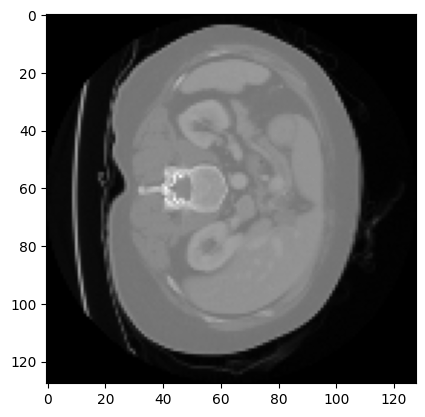

In [ ]:
# Visualise one of the unlabeled images
plt.imshow(im_batch[0,0,30,:,:], cmap='gray')

In [ ]:
# Create segmentations for unlabeled data

for i, (img) in enumerate(unlabeled_data):
    img = img.to(device=device, dtype=torch.float32)
    results = loaded_model(img)
    my_seg = torch.argmax(results, dim=1).float()
    my_seg = my_seg.squeeze(dim=0)
    img = nib.Nifti1Image(my_seg.cpu().numpy(), affine=np.eye(4))
    nib.save(img, f'/content/drive/MyDrive/FinalProjectML/unlab_seg/un_lab_{i+1}.nii.gz')


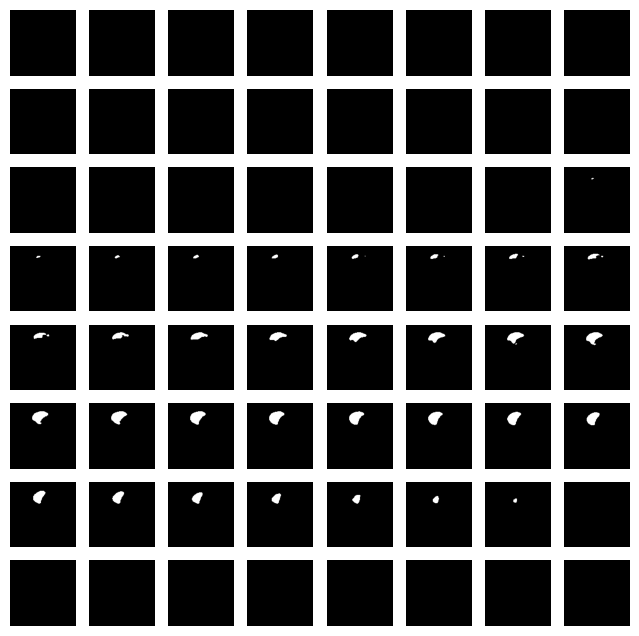

In [ ]:
# Visualise one of the unlabeled segmentation

loaded_seg = nib.load('/content/drive/MyDrive/FinalProjectML/unlab_seg/un_lab_1.nii.gz')
loaded_seg = loaded_seg.get_fdata()
loaded_seg = torch.from_numpy(loaded_seg)

rows = 8
cols = 8
fig = plt.figure(figsize=(8, 8))
plt.tight_layout()

for i in range(64):
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(loaded_seg[i, :, :].numpy(), cmap='gray')
    plt.axis('off')

torch.Size([64, 128, 128])


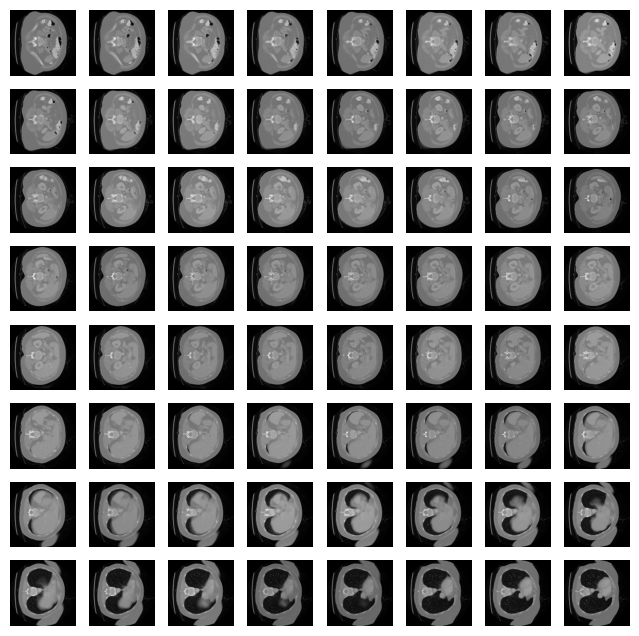

In [ ]:
# Visualise one of the unlabeled images to verify it mathes with the segmentation above

resizer = StandardResize()

loaded_seg = nib.load('/content/drive/MyDrive/FinalProjectML/Task09_Spleen/imagesTs/spleen_1.nii.gz')
loaded_seg = loaded_seg.get_fdata()
loaded_seg = torch.from_numpy(loaded_seg)
loaded_seg = torch.permute(loaded_seg, (2,0,1))
loaded_seg = resizer(loaded_seg)
print(loaded_seg.shape)

rows = 8
cols = 8
fig = plt.figure(figsize=(8, 8))
plt.tight_layout()

for i in range(64):
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(loaded_seg[i, :, :].numpy(), cmap='gray')
    plt.axis('off')

In [ ]:
# Create a dataloader for the training of the new network

DATA_PATH = '/content/drive/MyDrive/FinalProjectML/Task09_Spleen/imagesFn'
MASK_PATH = '/content/drive/MyDrive/FinalProjectML/Task09_Spleen/labelsFn'

transform_img = transforms.Compose([StandardResize(), MyNormalize()])
transform_mask = transforms.Compose([StandardResize()])

my_data = SpleenDataset(data=DATA_PATH, masks=MASK_PATH, img_transforms=transform_img, mask_transforms=transform_mask)
print(f'Data set length: {my_data.__len__()}')

# Separate in train and validation
train = torch.utils.data.Subset(my_data, range(40))
validation = torch.utils.data.Subset(my_data, range(40, 61))

train_data = torch.utils.data.DataLoader(train, batch_size=4, shuffle=True)
validation_data = torch.utils.data.DataLoader(validation, batch_size=4, shuffle=False)

im_batch, lab_batch = next(iter(train_data)) # get a batch
print(f'image batch shape:, {im_batch.shape}')
print(f'label batch shape:, {lab_batch.shape}')

Data set length: 61
image batch shape:, torch.Size([4, 1, 64, 128, 128])
label batch shape:, torch.Size([4, 1, 64, 128, 128])


In [ ]:
# Create training loop, define model, loss, and optimiser

model_aug_2 = UNET(1, 8, 2).to(device)
optimiser = torch.optim.Adam(model_aug_2.parameters(), lr=0.0001)
loss_fn = nn.CrossEntropyLoss()
epochs=100
mean_train_dice=[]
mean_val_dice=[]

for epoch in range(epochs):

    ##########
    # Train
    ##########
    
    model_aug_2.train() 
    train_dice= []

    for i, (data, label) in enumerate(train_data):
        data = data.to(device=device, dtype=torch.float32)
        label= label.to(device=device, dtype=torch.long)

        optimiser.zero_grad() 
        pred = model_aug_2(data)
        err = loss_fn(pred, label.squeeze(1))
        err.backward()
        optimiser.step()
        
        dice_value=dice_coeff(pred.argmax(dim=1), label).item()

        
        print('[{:d}/{:d}][{:d}/{:d}] Dice: {:.4f} '
              .format(epoch, epochs, i, len(train_data), dice_value))

        
        
        train_dice.append(dice_value)
      

    # #############
    # # Validation
    # #############
    
    # set network to eval prior to training loop 
    model_aug_2.eval()
    val_dice= []
    for i, (data, label) in enumerate(validation_data):
        data=data.to(device=device, dtype=torch.float32)
        label=label.to(device=device, dtype=torch.long)    

        pred = model_aug_2(data)
        
        err = loss_fn(pred, label.squeeze(1))
       
        val_dice.append(dice_coeff(pred.argmax(dim=1), label).item())

        
    mean_val_dice.append(np.mean(val_dice))
    mean_train_dice.append(np.mean(train_dice))

   

    print('Val Dice: {}, Train Dice: {:.4f}'.format(np.mean(mean_val_dice),np.mean(train_dice)))

    # Save the model every 20 epochs
    if epoch % 20 == 0:
        torch.save(model_aug_2.state_dict(), '/content/drive/MyDrive/FinalProjectML/model_4_1.pt')
# Save the model
torch.save(model_aug_2.state_dict(), '/content/drive/MyDrive/FinalProjectML/model_4_1.pt')

[0/100][0/10] Dice: 0.0144 
[0/100][1/10] Dice: 0.0091 
[0/100][2/10] Dice: 0.0082 
[0/100][3/10] Dice: 0.0208 
[0/100][4/10] Dice: 0.0111 
[0/100][5/10] Dice: 0.0130 
[0/100][6/10] Dice: 0.0182 
[0/100][7/10] Dice: 0.0109 
[0/100][8/10] Dice: 0.0132 
[0/100][9/10] Dice: 0.0093 
Val Dice: 0.0011465734084292005, Train Dice: 0.0128
[1/100][0/10] Dice: 0.0150 
[1/100][1/10] Dice: 0.0097 
[1/100][2/10] Dice: 0.0087 
[1/100][3/10] Dice: 0.0135 
[1/100][4/10] Dice: 0.0100 
[1/100][5/10] Dice: 0.0116 
[1/100][6/10] Dice: 0.0154 
[1/100][7/10] Dice: 0.0170 
[1/100][8/10] Dice: 0.0081 
[1/100][9/10] Dice: 0.0111 
Val Dice: 0.003728293944732286, Train Dice: 0.0120
[2/100][0/10] Dice: 0.0106 
[2/100][1/10] Dice: 0.0108 
[2/100][2/10] Dice: 0.0123 
[2/100][3/10] Dice: 0.0075 
[2/100][4/10] Dice: 0.0127 
[2/100][5/10] Dice: 0.0054 
[2/100][6/10] Dice: 0.0030 
[2/100][7/10] Dice: 0.0089 
[2/100][8/10] Dice: 0.0085 
[2/100][9/10] Dice: 0.0073 
Val Dice: 0.003937253072055885, Train Dice: 0.0087
[3/100

In [ ]:
# Load the model
loaded_model_4 = UNET(1, 8, 2)
loaded_model_4.load_state_dict(torch.load('/content/drive/MyDrive/FinalProjectML/model_4_1.pt', map_location=torch.device(device)))
loaded_model_4.eval()

UNET(
  (first_conv): DoubleConv(
    (double_conv): Sequential(
      (0): MyConv(
        (conv1): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      )
      (1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MyConv(
        (conv1): Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      )
      (4): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (down_conv1): DownConv(
    (encoder): Sequential(
      (0): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): MyConv(
            (conv1): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          )
          (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): MyConv(
        

In [ ]:
# Calculate the dice, to make a fair dice comparisson with other models, the same validation data as task 1 is used

validation_data2 = torch.utils.data.DataLoader(validation, batch_size=1, shuffle=False)
loaded_model_4.to(device)
list_of_dice = []
for i, (data, label) in enumerate(validation_data2):
    data = data.to(device=device, dtype=torch.float32)
    label= label.to(device=device, dtype=torch.long)
    results = loaded_model_4(data)
    dice = dice_coeff(results.argmax(dim=1), label).cpu().numpy()
    list_of_dice.append(dice)

print(np.mean(list_of_dice))

0.10887915


### Part 5
The process of image segmentation is naturally uncertain. Because of this, we would like to estimate how uncertaint the models are when segmenting the target labels. To
 
achieve this, please implement the Dropout only method, as decribed here (http://proceedings.mlr.press/v48/gal16.pdf). Optimise any parameters the method might have. Visualise the uncertainty estimates. Are the areas of high uncertainty areas where errors are more likeley to be made?

In [47]:
# Modify the UNET class to perform dropout

class MyConv(nn.Module):
    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.conv1 = nn.Conv3d(channels_in, channels_out, kernel_size=3, stride=1, padding=1)
    def forward(self, x):
        return self.conv1(x)

# Notice that BatchNorm is removed
class DoubleConv(nn.Module):
    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.double_conv = nn.Sequential(
            MyConv(channels_in, channels_out),
            nn.ReLU(),

            MyConv(channels_out, channels_out),
            nn.ReLU(),
        )
    def forward(self, x):
        return self.double_conv(x)


class DownConv(nn.Module):
    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.MaxPool3d(2, 2),
            DoubleConv(channels_in, channels_out)
        )
    def forward(self, x):
        return self.encoder(x)


class UpConv(nn.Module):
    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.upsample_layer = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='trilinear'),
            nn.Conv3d(channels_in, channels_in//2, kernel_size=1, stride=1)
        )
        self.decoder = DoubleConv(channels_in, channels_out)
    def forward(self, x1, x2):
        x1 = self.upsample_layer(x1)
        x = torch.cat([x2, x1], dim=1)
        return self.decoder(x)

# Notice that in the forward method dropout is applied
class UNET_DO(nn.Module):
    def __init__(self, channels_in, channels, num_classes, dropout_prob=0.0):
        super().__init__()
        self.first_conv = DoubleConv(channels_in, channels)
        self.down_conv1 = DownConv(channels, 2*channels)
        self.down_conv2 = DownConv(2*channels, 4*channels)
        self.down_conv3 = DownConv(4*channels, 8*channels)

        self.down_conv4 = DownConv(8*channels, 16*channels)

        self.up_conv1 = UpConv(16*channels, 8*channels)
        self.up_conv2 = UpConv(8*channels, 4*channels)
        self.up_conv3 = UpConv(4*channels, 2*channels)
        self.up_conv4 = UpConv(2*channels, channels)

        self.final_conv = nn.Conv3d(channels, num_classes, kernel_size=1, stride=1)

        self.dropout_prob = dropout_prob
        self.dropout = nn.Dropout(p=self.dropout_prob)

    def forward(self, x):
        x1 = self.first_conv(x)
        x2 = self.dropout(self.down_conv1(x1))
        x3 = self.dropout(self.down_conv2(x2))
        x4 = self.dropout(self.down_conv3(x3))

        x5 = self.dropout(self.down_conv4(x4))

        u1 = self.dropout(self.up_conv1(x5, x4))
        u2 = self.dropout(self.up_conv2(u1, x3))
        u3 = self.dropout(self.up_conv3(u2, x2))
        u4 = self.dropout(self.up_conv4(u3, x1))

        return self.final_conv(u4)

In [56]:
# Create dataloaders
DATA_PATH = '/content/drive/MyDrive/FinalProjectML/Task09_Spleen/imagesTr'
MASK_PATH = '/content/drive/MyDrive/FinalProjectML/Task09_Spleen/labelsTr'

transform_img = transforms.Compose([StandardResize(), MyNormalize()])
transform_mask = transforms.Compose([StandardResize()])

my_data = SpleenDataset(data=DATA_PATH, masks=MASK_PATH, img_transforms=transform_img, mask_transforms=transform_mask)
print(f'Data set length: {my_data.__len__()}')

# Create train and validation data
train = torch.utils.data.Subset(my_data, range(30))
validation = torch.utils.data.Subset(my_data, range(30, 41))

train_data = torch.utils.data.DataLoader(train, batch_size=4, shuffle=True)
validation_data = torch.utils.data.DataLoader(validation, batch_size=4, shuffle=False)

Data set length: 41


In [ ]:
# Create training loop, define model, loss, and optimiser
model_do = UNET_DO(1, 8, 2, dropout_prob=0.5).to(device)
optimiser = torch.optim.Adam(model_do.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
epochs=100
mean_train_dice=[]
mean_val_dice=[]

for epoch in range(epochs):

    ##########
    # Train
    ##########
    
    model_do.train() 
    train_dice= []

    for i, (data, label) in enumerate(train_data):
        data = data.to(device=device, dtype=torch.float32)
        label= label.to(device=device, dtype=torch.long)

        optimiser.zero_grad() 
        pred = model_do(data)
        err = loss_fn(pred, label.squeeze(1))
        err.backward()
        optimiser.step()
        
        dice_value=dice_coeff(pred.argmax(dim=1), label).item()

        
        print('[{:d}/{:d}][{:d}/{:d}] Dice: {:.4f} '
              .format(epoch, epochs, i, len(train_data), dice_value))

        
        
        train_dice.append(dice_value)
      

    # #############
    # # Validation
    # #############
    
    # set network to eval prior to training loop 
    model_do.eval()
    val_dice= []
    for i, (data, label) in enumerate(validation_data):
        data=data.to(device=device, dtype=torch.float32)
        label=label.to(device=device, dtype=torch.long)    

        pred = model_do(data)
        
        err = loss_fn(pred, label.squeeze(1))
       
        val_dice.append(dice_coeff(pred.argmax(dim=1), label).item())

        
    mean_val_dice.append(np.mean(val_dice))
    mean_train_dice.append(np.mean(train_dice))

   

    print('Val Dice: {}, Train Dice: {:.4f}'.format(np.mean(mean_val_dice),np.mean(train_dice)))

    # Save model every 20 epochs
    if epoch % 20 == 0:
        torch.save(model_do.state_dict(), '/content/drive/MyDrive/FinalProjectML/model_5_1.pt')
# Save the model
torch.save(model_do.state_dict(), '/content/drive/MyDrive/FinalProjectML/model_5_1.pt')

[0/100][0/8] Dice: 0.0091 
[0/100][1/8] Dice: 0.0162 
[0/100][2/8] Dice: 0.0045 
[0/100][3/8] Dice: 0.0079 
[0/100][4/8] Dice: 0.0131 
[0/100][5/8] Dice: 0.0099 
[0/100][6/8] Dice: 0.0083 
[0/100][7/8] Dice: 0.0106 
Val Dice: 0.0, Train Dice: 0.0100
[1/100][0/8] Dice: 0.0075 
[1/100][1/8] Dice: 0.0067 
[1/100][2/8] Dice: 0.0062 
[1/100][3/8] Dice: 0.0077 
[1/100][4/8] Dice: 0.0157 
[1/100][5/8] Dice: 0.0082 
[1/100][6/8] Dice: 0.0138 
[1/100][7/8] Dice: 0.0182 
Val Dice: 0.0, Train Dice: 0.0105
[2/100][0/8] Dice: 0.0120 
[2/100][1/8] Dice: 0.0140 
[2/100][2/8] Dice: 0.0052 
[2/100][3/8] Dice: 0.0083 
[2/100][4/8] Dice: 0.0116 
[2/100][5/8] Dice: 0.0121 
[2/100][6/8] Dice: 0.0066 
[2/100][7/8] Dice: 0.0109 
Val Dice: 0.0, Train Dice: 0.0101
[3/100][0/8] Dice: 0.0115 
[3/100][1/8] Dice: 0.0112 
[3/100][2/8] Dice: 0.0132 
[3/100][3/8] Dice: 0.0074 
[3/100][4/8] Dice: 0.0054 
[3/100][5/8] Dice: 0.0143 
[3/100][6/8] Dice: 0.0082 
[3/100][7/8] Dice: 0.0078 
Val Dice: 0.0, Train Dice: 0.0099


In [ ]:
# Extend the training procesds for 100 more epochs, so the model is trained for a total of 200 epochs
for epoch in range(epochs):

    ##########
    # Train
    ##########
    
    model_do.train() 
    train_dice= []

    for i, (data, label) in enumerate(train_data):
        data = data.to(device=device, dtype=torch.float32)
        label= label.to(device=device, dtype=torch.long)

        optimiser.zero_grad() 

        pred = model_do(data)
        err = loss_fn(pred, label.squeeze(1))

        err.backward()
        optimiser.step()
        
        dice_value=dice_coeff(pred.argmax(dim=1), label).item()

        
        print('[{:d}/{:d}][{:d}/{:d}] Dice: {:.4f} '
              .format(epoch, epochs, i, len(train_data), dice_value))

        
        
        train_dice.append(dice_value)
      

    # #############
    # # Validation
    # #############
    
    # set network to eval prior to training loop 
    model_do.eval()
    val_dice= []
    for i, (data, label) in enumerate(validation_data):
        data=data.to(device=device, dtype=torch.float32)
        label=label.to(device=device, dtype=torch.long)    

        pred = model_do(data)
        
        err = loss_fn(pred, label.squeeze(1))
       
        val_dice.append(dice_coeff(pred.argmax(dim=1), label).item())

        
    mean_val_dice.append(np.mean(val_dice))
    mean_train_dice.append(np.mean(train_dice))

   

    print('Val Dice: {}, Train Dice: {:.4f}'.format(np.mean(mean_val_dice),np.mean(train_dice)))
    # Save the model every 20 epochs
    if epoch % 20 == 0:
        torch.save(model_do.state_dict(), '/content/drive/MyDrive/FinalProjectML/model_5_2.pt')
#  Save the model
torch.save(model_do.state_dict(), '/content/drive/MyDrive/FinalProjectML/model_5_2.pt')

[0/100][0/8] Dice: 0.3754 
[0/100][1/8] Dice: 0.2058 
[0/100][2/8] Dice: 0.2829 
[0/100][3/8] Dice: 0.1977 
[0/100][4/8] Dice: 0.2628 
[0/100][5/8] Dice: 0.3091 
[0/100][6/8] Dice: 0.2829 
[0/100][7/8] Dice: 0.4033 
Val Dice: 0.25524041479262877, Train Dice: 0.2900
[1/100][0/8] Dice: 0.4211 
[1/100][1/8] Dice: 0.2584 
[1/100][2/8] Dice: 0.2345 
[1/100][3/8] Dice: 0.2579 
[1/100][4/8] Dice: 0.3571 
[1/100][5/8] Dice: 0.3037 
[1/100][6/8] Dice: 0.3244 
[1/100][7/8] Dice: 0.3976 
Val Dice: 0.25705150460970466, Train Dice: 0.3193
[2/100][0/8] Dice: 0.2585 
[2/100][1/8] Dice: 0.3301 
[2/100][2/8] Dice: 0.2271 
[2/100][3/8] Dice: 0.2669 
[2/100][4/8] Dice: 0.3202 
[2/100][5/8] Dice: 0.3040 
[2/100][6/8] Dice: 0.4587 
[2/100][7/8] Dice: 0.3585 
Val Dice: 0.2587547672574912, Train Dice: 0.3155
[3/100][0/8] Dice: 0.2608 
[3/100][1/8] Dice: 0.4369 
[3/100][2/8] Dice: 0.2198 
[3/100][3/8] Dice: 0.2893 
[3/100][4/8] Dice: 0.3763 
[3/100][5/8] Dice: 0.2724 
[3/100][6/8] Dice: 0.2112 
[3/100][7/8] D

In [48]:
# Load the model
loaded_model_5 = UNET_DO(1, 8, 2, dropout_prob=0.5)
loaded_model_5.load_state_dict(torch.load('/content/drive/MyDrive/FinalProjectML/model_5_2.pt', map_location=torch.device(device)))
loaded_model_5.eval()

UNET_DO(
  (first_conv): DoubleConv(
    (double_conv): Sequential(
      (0): MyConv(
        (conv1): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      )
      (1): ReLU()
      (2): MyConv(
        (conv1): Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      )
      (3): ReLU()
    )
  )
  (down_conv1): DownConv(
    (encoder): Sequential(
      (0): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): MyConv(
            (conv1): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          )
          (1): ReLU()
          (2): MyConv(
            (conv1): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          )
          (3): ReLU()
        )
      )
    )
  )
  (down_conv2): DownConv(
    (encoder): Sequential(
      (0): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, 

In [ ]:
#  Calculate validation dice using same validation datasets as in previous calculations
validation_data2 = torch.utils.data.DataLoader(validation, batch_size=1, shuffle=False)
loaded_model_5.to(device)
list_of_dice = []
for i, (data, label) in enumerate(validation_data2):
    data = data.to(device=device, dtype=torch.float32)
    label= label.to(device=device, dtype=torch.long)
    results = loaded_model_5(data)
    dice = dice_coeff(results.argmax(dim=1), label).cpu().numpy()
    list_of_dice.append(dice)

print(np.mean(list_of_dice))

0.8245312


In [ ]:
#  Calculate the models uncertainty using the validation data
# For this the data is passed 10 times thorugh the model with dropout and the mean and var are calculated

# .train() is used to activate dropout
loaded_model_5.train()
final_mean = []
final_var = []
for i, (data, _) in enumerate(validation_data2):
    data = data.to(device=device, dtype=torch.float32)
    outputs = []
    for j in range(10):
        with torch.no_grad():
            pred = loaded_model_5(data).argmax(dim=1).cpu().numpy()
            outputs.append(pred)
    mean = np.mean(outputs)
    variance = np.var(outputs)
    final_mean.append(mean)
    final_var.append(variance)
    print(f'Validation Sample {i+1} | Mean: {mean:.4f}, Variance: {variance:.4f}')

# Print the final uncertainty
print(f'UNCERTAINTY | Mean: {np.mean(final_mean):.4f} Variance: {np.mean(final_var):.4f}')

Validation Sample 1 | Mean: 0.0023, Variance: 0.0023
Validation Sample 2 | Mean: 0.0014, Variance: 0.0013
Validation Sample 3 | Mean: 0.0032, Variance: 0.0031
Validation Sample 4 | Mean: 0.0069, Variance: 0.0069
Validation Sample 5 | Mean: 0.0041, Variance: 0.0041
Validation Sample 6 | Mean: 0.0028, Variance: 0.0028
Validation Sample 7 | Mean: 0.0021, Variance: 0.0020
Validation Sample 8 | Mean: 0.0047, Variance: 0.0047
Validation Sample 9 | Mean: 0.0046, Variance: 0.0045
Validation Sample 10 | Mean: 0.0080, Variance: 0.0079
Validation Sample 11 | Mean: 0.0082, Variance: 0.0081
UNCERTAINTY | Mean: 0.0044 Variance: 0.0043


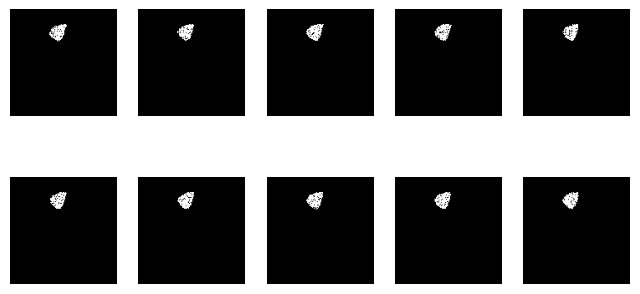

In [ ]:
# Visualise 10 output segmentations for a single input image to see that they are different, therefore the model has uncertainty
rows = 2
cols = 5
fig = plt.figure(figsize=(8, 4))
plt.tight_layout()

list_of_pred = []
for i, (data, _) in enumerate(validation_data2):
    data = data.to(device=device, dtype=torch.float32)
    for j in range(10):
        with torch.no_grad():
            pred = loaded_model_5(data).argmax(dim=1).cpu().numpy()
            list_of_pred.append(pred)
            fig.add_subplot(rows, cols, j+1)
            plt.imshow(pred[0,50, :, :], cmap='gray')
            plt.axis('off')
    if i == 0:
        break

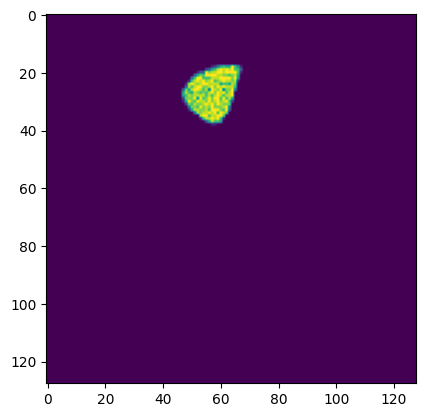

In [ ]:
# Visualise uncertainty, brighter areas are places were the model is less uncertain.
plt.imshow(np.sum(list_of_pred, axis=0)[0, 50, :, :])

In [57]:
# Save the segmentations from the last model
loaded_model_5.eval()
loaded_model_5.to(device)
all_data = torch.utils.data.DataLoader(my_data, batch_size=1, shuffle=False)
len(all_data)

for i, (data, label) in enumerate(all_data):
    data = data.to(device=device, dtype=torch.float32)
    label= label.to(device=device, dtype=torch.long)
    results = loaded_model_5(data)
    my_seg = torch.argmax(results, dim=1).float()
    my_seg = my_seg.squeeze(dim=0)
    img = nib.Nifti1Image(my_seg.cpu().numpy(), affine=np.eye(4))
    nib.save(img, f'/content/drive/MyDrive/FinalProjectML/members_segmentations/martin2/spleen_{i+1}_MF.nii.gz')